# A/B тест

В данном проект я проведу А/В тестирование по данным: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?resource=download

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.stats.api as sms
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Кирилл/Desktop/Аналитик данных/ПЭТ проекты/A-B test 1/ab_data.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [3]:
# Функция проверки качества данных
def initial_inspection(df):
    
    print("=== ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ ===")
    
    # Первые 5 строк
    print("\n1. Первые 5 строк данных:")
    print(df.head())
    
    # Информация о данных
    print("\n2. Информация о структуре данных:")
    print(df.info())
    
    # Описательная статистика
    print("\n3. Описательная статистика:")
    print(df.describe())
    
    # Проверка на пропуски
    print("\n4. Проверка на пропущенные значения:")
    missing_values = df.isnull().sum()
    print(missing_values)
    
    return df

In [4]:
initial_inspection(df)

=== ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ ===

1. Первые 5 строк данных:
   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

2. Информация о структуре данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


В датасете представлены следующие данные:
 - user_id: id пользователя;
 - timestamp: время события;
 - group: тип группы - контрольная и тестовая;
 - landing_page: тип просматриваемой страницы - новая и старая страницы;
 - converted: целевое действие.

Пропущенные значения отсутствуют.

In [5]:
# Должны быть только две группы: control и treatment
print("Уникальные группы:", df['group'].unique())

# Должны быть только две страницы: old_page и new_page
print("Уникальные страницы:", df['landing_page'].unique())

# Проверяем соответствие: control -> old_page, treatment -> new_page
cross_tab = pd.crosstab(df['group'], df['landing_page'])
print("\nСоответствие групп и страниц:")
print(cross_tab)

Уникальные группы: ['control' 'treatment']
Уникальные страницы: ['old_page' 'new_page']

Соответствие групп и страниц:
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


Здесь видно, что 1928 пользователей из контрольной группы видели новую страницу, а 1965 пользователей из тестовой группы видели старую страницу. Это помешает качественному А/В тесту.

## Обработка данных

In [6]:
df_an = df.copy()
df_min_date = df.copy()
# меняем тип данных столбца timestamp на datetime
df_min_date["timestamp"] = pd.to_datetime(df_min_date["timestamp"])
df_an["timestamp"] = pd.to_datetime(df_an["timestamp"])

In [7]:
df_an

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [8]:
# фильтруем только первую запись timestamp для каждого user_id, чтобы убрать повторные сессии
df_min_date = df_min_date.groupby("user_id").min()["timestamp"].reset_index()
df_min_date

,user_id,timestamp
0,630000,2017-01-19 06:26:06.548941
1,630001,2017-01-16 03:16:42.560309
2,630002,2017-01-19 19:20:56.438330
3,630003,2017-01-12 10:09:31.510471
4,630004,2017-01-18 20:23:58.824994
...,...,...
290579,945994,2017-01-03 14:41:21.565258
290580,945996,2017-01-09 18:58:19.952277
290581,945997,2017-01-04 06:56:24.658147
290582,945998,2017-01-16 07:08:02.207969


In [9]:
# соединяем таблицы df_an и df_min_date
df_an = df_an.merge(df_min_date, on = ["user_id", "timestamp"], how = "inner")
# получаем таблицу без повторных сессий пользователей
df_an

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [10]:
# Проверяем соответствие: control -> old_page, treatment -> new_page
cross_tab = pd.crosstab(df_an['group'], df_an['landing_page'])
print("\nСоответствие групп и страниц:")
print(cross_tab)


Соответствие групп и страниц:
landing_page  new_page  old_page
group                           
control            975    144319
treatment       144316       974


У нас по-прежнему остались пользователи в каждой из групп,. которые видели обе страницы. Таких пользователей необходимо удалить, так как они будут искажать A/B тест.

In [11]:
# Находим user_id с некорректными соответствиями групп и страниц
incorrect_users = df_an[
    ((df_an['group'] == 'control') & (df_an['landing_page'] != 'old_page')) |
    ((df_an['group'] == 'treatment') & (df_an['landing_page'] != 'new_page'))
]['user_id'].unique()
incorrect_users

array([686623, 820951, 637639, ..., 813406, 928506, 689637], dtype=int64)

In [12]:
# Удаляем все записи этих пользователей
df_cleaned = df_an[~df_an['user_id'].isin(incorrect_users)]

In [13]:
df_cleaned

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [14]:
# Проверяем соответствие: control -> old_page, treatment -> new_page
cross_tab1 = pd.crosstab(df_cleaned['group'], df_cleaned['landing_page'])
print("\nСоответствие групп и страниц:")
print(cross_tab1)


Соответствие групп и страниц:
landing_page  new_page  old_page
group                           
control              0    144319
treatment       144316         0


In [15]:
# Проверим, есть ли пользователи, которые встречаются больше одного раза
duplicate_users = df_cleaned['user_id'].duplicated().sum()
print(f"Количество повторяющихся user_id: {duplicate_users}")

Количество повторяющихся user_id: 0


## Проверка временного периода эксперимента

Начало эксперимента: 2017-01-02 13:42:05.378582
Конец эксперимента: 2017-01-24 13:41:54.460509
Длительность эксперимента: 21 days 23:59:49.081927


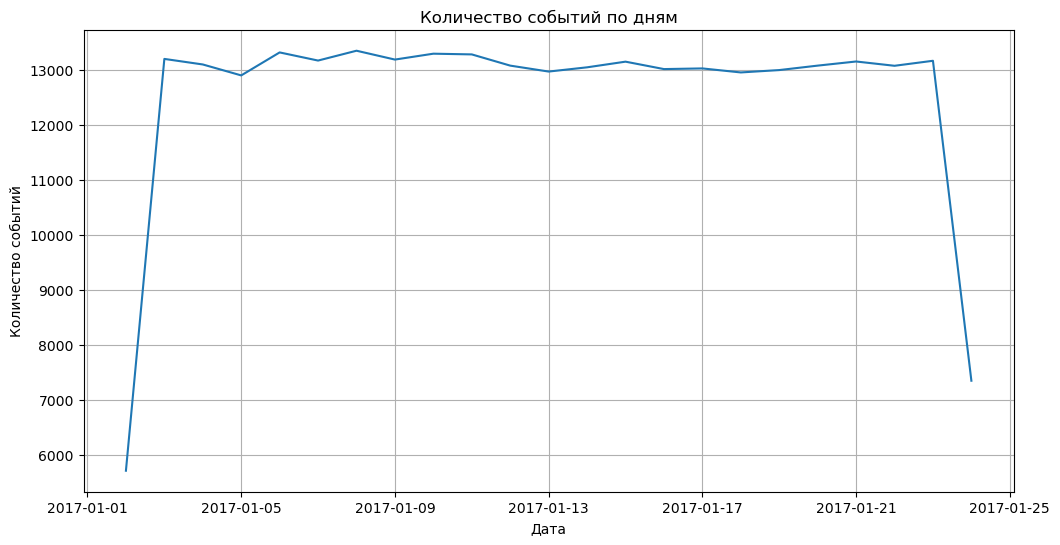

In [16]:
# Проверим временной период эксперимента
print("Начало эксперимента:", df_cleaned['timestamp'].min())
print("Конец эксперимента:", df_cleaned['timestamp'].max())
print("Длительность эксперимента:", df_cleaned['timestamp'].max() - df_cleaned['timestamp'].min())

# Построим график количества событий по дням
df_cleaned['date'] = df_cleaned['timestamp'].dt.date
daily_counts = df_cleaned.groupby('date')['user_id'].count()
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', title='Количество событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid()
plt.show()

Эксперимент длился ровное количество дней.

Трафик распределен равномерно.

In [17]:
# Посчитаем количество пользователей в каждой группе
group_counts = df_cleaned['group'].value_counts()
print("Распределение по группам:")
print(group_counts)

# В идеале соотношение должно быть близко к 50/50
print(f"\nСоотношение: {group_counts['control']/group_counts.sum():.3f} : {group_counts['treatment']/group_counts.sum():.3f}")

# Проверим статистическую значимость различия в размерах групп (Xи-квадрат)
chi2, p_value, _, _ = chi2_contingency([group_counts.values])
print(f"p-value для проверки равномерности распределения: {p_value:.4f}")

Распределение по группам:
group
control      144319
treatment    144316
Name: count, dtype: int64

Соотношение: 0.500 : 0.500
p-value для проверки равномерности распределения: 1.0000


Соотношение групп 50/50.

p-value > 0.05: Различия в размерах групп статистически не значимы.

In [18]:
# Проверим значения converted
print("Уникальные значения converted:", df_cleaned['converted'].unique())

# Посчитаем конверсию в группах на этом этапе (только для справки, пока без теста)
conversion_rates = df_cleaned.groupby('group')['converted'].mean()
print("\nКонверсия по группам (предварительно):")
print(conversion_rates)

Уникальные значения converted: [0 1]

Конверсия по группам (предварительно):
group
control      0.120393
treatment    0.118698
Name: converted, dtype: float64


Видим, что нет аномально высокого процента конверсий по группам.

# А/В тест

Гипотезы:
 - H0: Конверсия в контрольной группе равна конверсии в экспериментальной группе.
 - H1: Конверсии в группах различаются.

In [19]:
# Установка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Рассчитаем основные метрики по группам
grouped = df_cleaned.groupby('group')['converted'].agg(['count', 'mean', 'std'])

# Добавим доверительные интервалы для конверсии
def get_ci_proportion(mean, count, alpha=0.05):
    """Вычисляет доверительный интервал для пропорции"""
    se = np.sqrt(mean * (1 - mean) / count) # стандартная ошибка пропорции
    z = stats.norm.ppf(1 - alpha/2) # Z-значение для заданного уровня значимости (по умолчанию 95% ДИ)
    return mean - z * se, mean + z * se # возвращает нижнюю и верхнюю границы доверительного интервала

# Применяем функцию для расчета доверительных интервалов
grouped['ci_lower'] = grouped.apply(lambda x: get_ci_proportion(x['mean'], x['count'])[0], axis=1)
grouped['ci_upper'] = grouped.apply(lambda x: get_ci_proportion(x['mean'], x['count'])[1], axis=1)

print("Основные метрики по группам:")
print(grouped)

Основные метрики по группам:
            count      mean       std  ci_lower  ci_upper
group                                                    
control    144319  0.120393  0.325422  0.118714  0.122072
treatment  144316  0.118698  0.323434  0.117029  0.120367


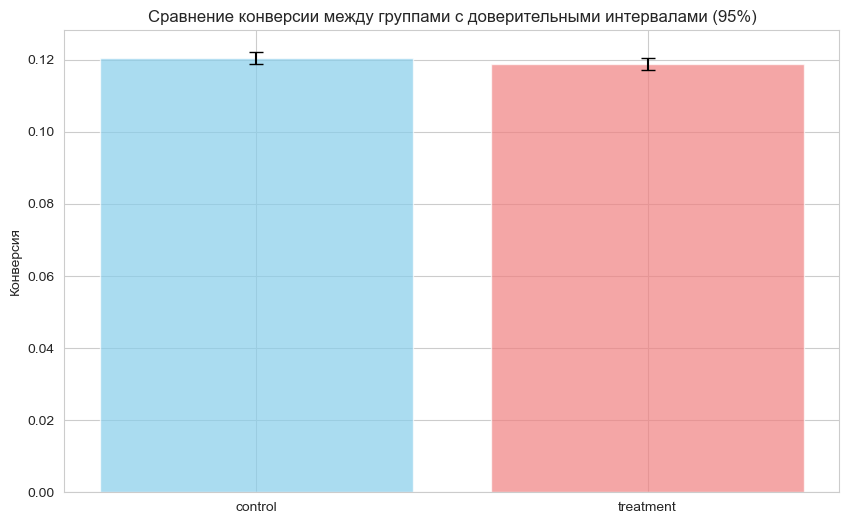

In [20]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
groups = grouped.index
means = grouped['mean']
cis_lower = grouped['ci_lower']
cis_upper = grouped['ci_upper']

plt.bar(groups, means, yerr=[means - cis_lower, cis_upper - means], 
        capsize=5, alpha=0.7, color=['skyblue', 'lightcoral'])
plt.ylabel('Конверсия')
plt.title('Сравнение конверсии между группами с доверительными интервалами (95%)')
plt.show()

График показывает, что тестовая группа (treatment) не показала значительного увеличения конверсии.

In [21]:
# Проведем статистический тест
# Разделяем данные на две группы
control_conversions = df_cleaned[df_cleaned['group'] == 'control']['converted']
treatment_conversions = df_cleaned[df_cleaned['group'] == 'treatment']['converted']

# Вычисляем размеры выборок и количество конверсий
n_control = len(control_conversions)
n_treatment = len(treatment_conversions)
conv_control = control_conversions.sum()
conv_treatment = treatment_conversions.sum()

print(f"Контрольная группа: {n_control} пользователей, {conv_control} конверсий")
print(f"Экспериментальная группа: {n_treatment} пользователей, {conv_treatment} конверсий")

Контрольная группа: 144319 пользователей, 17375 конверсий
Экспериментальная группа: 144316 пользователей, 17130 конверсий


In [22]:
# Проводим Z-тест для пропорций
z_score, p_value = sms.proportions_ztest(
    [conv_control, conv_treatment], 
    [n_control, n_treatment]
)

print(f"Z-статистика: {z_score:.4f}") # величина Z-статистики, показывающая, насколько отличаются пропорции
print(f"P-value: {p_value:.4f}") # вероятность получить такие же результаты при условии, что нулевая гипотеза верна

# Рассчитаем доверительный интервал для разницы пропорций
effect_size = conv_treatment/n_treatment - conv_control/n_control
se = np.sqrt(conv_control/n_control * (1 - conv_control/n_control) / n_control + 
             conv_treatment/n_treatment * (1 - conv_treatment/n_treatment) / n_treatment)
ci_lower = effect_size - 1.96 * se
ci_upper = effect_size + 1.96 * se

print(f"Разница в конверсии: {effect_size:.4f}")
print(f"95% доверительный интервал разницы: [{ci_lower:.4f}, {ci_upper:.4f}]")

Z-статистика: 1.4036
P-value: 0.1604
Разница в конверсии: -0.0017
95% доверительный интервал разницы: [-0.0041, 0.0007]


Z-статистика: 1.4036

Значение 1.4036 означает, что разница между группами составляет примерно 1.4 стандартных ошибки. Для уровня значимости α = 0.05 (95% доверительный уровень) критические значения Z составляют ±1.96. Так как Z-статистика (1.4036) меньше критического значения 1.96, это говорит о том что мы не можем отвергнуть нулевую гипотезу о равенстве конверсий в группах

P-value: 0.1604. 

Это значение больше общепринятого уровня значимости 0.05.
Вывод: Нет статистически значимых доказательств того, что разница между группами реальна.
Вероятность получить такие результаты случайно (при отсутствии реальной разницы) составляет 16,04%.

Разница в конверсии: -0.0017

Экспериментальная группа (treatment) показала конверсию на 0.17% хуже, чем контрольная группа.
Это очень небольшая разница, особенно учитывая, что она статистически незначима

Доверительный интервал: [-0.0041, 0.0007]

С 95% уверенностью можно сказать, что истинная разница в конверсии находится между -0,41% и +0,07%.
Интервал включает ноль, что подтверждает отсутствие статистической значимости.
Интервал асимметричен относительно нуля, что указывает на возможное небольшое отрицательное влияние новой версии

Не удалось отвергнуть нулевую гипотезу: статистически значимой разницы между группами не обнаружено.


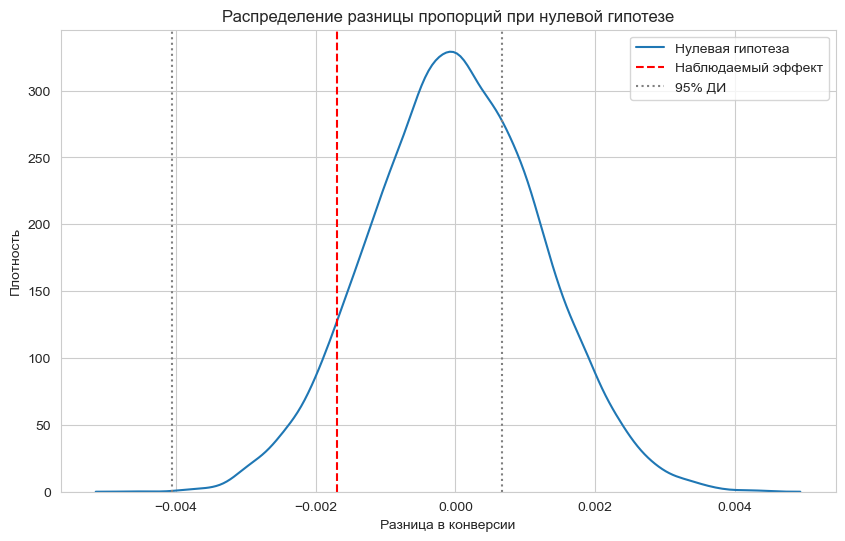

Мощность теста: 0.2894


In [23]:
# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимая разница между группами.")
    if effect_size > 0:
        print(f"Новая версия увеличила конверсию на {effect_size*100:.2f}%.")
    else:
        print(f"Новая версия уменьшила конверсию на {abs(effect_size)*100:.2f}%.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: статистически значимой разницы между группами не обнаружено.")

# Дополнительная визуализация: распределение разницы
plt.figure(figsize=(10, 6))
sns.kdeplot(np.random.normal(0, se, 10000), label='Нулевая гипотеза')
plt.axvline(x=effect_size, color='red', linestyle='--', label='Наблюдаемый эффект')
plt.axvline(x=ci_lower, color='gray', linestyle=':', label='95% ДИ')
plt.axvline(x=ci_upper, color='gray', linestyle=':')
plt.xlabel('Разница в конверсии')
plt.ylabel('Плотность')
plt.title('Распределение разницы пропорций при нулевой гипотезе')
plt.legend()
plt.show()

# Расчет мощности теста
effect = sms.proportion_effectsize(conv_control/n_control, conv_treatment/n_treatment)
power = sms.TTestIndPower().power(
    effect_size=effect,
    nobs1=n_control,
    alpha=0.05,
    ratio=n_treatment/n_control
)
print(f"Мощность теста: {power:.4f}")

Мощность теста говорит о том, что если новая версия страницы действительно улучшает конверсию, то наш тест имеет только 28.94% шанс это обнаружить.

Статистический вывод: Не отвергаем нулевую гипотезу. Нет доказательств того, что новая версия страницы повлияла на конверсию. И соответственно мы имеем 71.06% вероятность совершить ошибку 2-го рода (пропустить существующий эффект).

Причины низкой мощности: недостаточный размер выборки или слишком маленький эффект.

В итоге отсутствие статистической значимости не означает отсутствия эффекта. Возможно, эффект есть, но наш тест не имеет достаточной мощности для его обнаружения.

Вывод: нельзя сделать вывод о том, что "новая версия не работает". Можно лишь сделать вывод о том, что не удалось обнаружить статистически значимого эффекта при текущей мощности теста.